### 1. package imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.interpolate import NearestNDInterpolator
import numpy as np
import tqdm
from pathlib import Path
import geopandas as gpd
import rasterio as rio
from rasterio.mask import mask as riomask
from rasterio.transform import xy as rioxy
from rasterio.transform import rowcol as riorowcol
from shapely.geometry import Point, box
from scipy.interpolate import interp2d
import xarray as xr
# import holoviews as hv
from IPython.display import HTML, display
import warnings
warnings.filterwarnings("ignore")
from tqdm.notebook import tqdm as ntqdm

# personal imports
from Extract_precipitations import read_meteo_stations_in_pandas

### 2. specify folders and paths

In [11]:
# INPUTS
# an example file is needed to create the pixel grid of the interpolated Precipitation and Temperature
example_file = "/mnt/RAID2/ACCWA/h18v04/dispatch_hybrid_11r/20200926/SM1km_h18v04_20200926_P11r.asc"

shapefile_path = Path("/data/PhDGiovanni/5.IrriEst/DATA/INSITU/Urgell/urgell_shape.geojson")
shapefile = gpd.read_file(shapefile_path).to_crs(4326)
### if you don't have a shapefile ready, then comment the previous 2 lines and uncomment the following lines and specify just the border extent 
# west = 0.8
# south = 41.5
# east = 1.1
# north = 41.8
# shapefile = gpd.GeoDataFrame(geometry=[box(west, south, east, north)], crs = "EPSG:4326")

### PARAMETERS
start_date = "01/01/2023" # format: "dd/mm/yyyy"
end_date   = "31/12/2023"

### OUTPUTS
outfold = Path("/data/PhDGiovanni/5.IrriEst/CODE/GIT_prism/PrISM/examples")
outfold.mkdir(exist_ok=True, parents=True)

## 1. DOWNLOAD Precipitation data

[Text(0.5, 1.0, '44 meteo stations selected')]

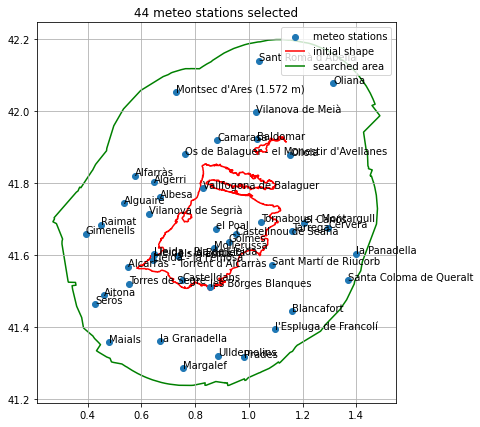

In [12]:
## 1. IN-SITU PRECIPITATION - Resampled to every 3 hours
### search for the meteostations in the area
meteocat_stations_file = Path.cwd() / "XEMA_meteostations.geojson"
meteocat_stations = gpd.read_file(meteocat_stations_file)
buff = 30000
selected_stations = meteocat_stations[meteocat_stations.intersects(shapefile.to_crs(meteocat_stations.crs).buffer(buff, cap_style=3, join_style=3).geometry[0])]
selected_stations = selected_stations.to_crs(4326)
ds = pd.Timestamp(start_date)
de = pd.Timestamp(end_date)

# PLOT result of the search
ax=selected_stations.plot(figsize = (8,7), zorder = 3, label = "meteo stations")
shapefile.to_crs(selected_stations.crs).boundary.plot(ax=ax, zorder = 2, color = "red", label = "initial shape")
shapefile.to_crs(meteocat_stations.crs).buffer(buff, cap_style=3, join_style=3).to_crs(selected_stations.crs).boundary.plot(ax=ax, zorder = 1, color = "green", label = "searched area")

delta = 0.001
for ii, dd in selected_stations[['names','geometry']].iterrows():
    ax.annotate(dd.names, xy = (dd.geometry.x,dd.geometry.y+delta))
ax.grid()
ax.legend()
ax.set(title=f"{len(selected_stations)} meteo stations selected")



In [13]:
# example_file = "/data/PhDGiovanni/DISPATCH_Lleida_20m/INPUTS/NDVI_Catalunya/data/NDVI/2020/merged/NDVI_S2A_20200207_noclouds.tiff"
# ff = xr.open_dataset(example_file, engine = 'rasterio', masked=True)
# boarderss = gpd.GeoSeries([box(*ff.rio.bounds())], crs = ff.rio.crs).to_crs(4326)

In [14]:
# buff = 45000

# selected_stations = meteocat_stations[meteocat_stations.intersects(shapefile.to_crs(meteocat_stations.crs).buffer(buff, cap_style=3, join_style=3).geometry[0])]
# selected_stations = selected_stations.to_crs(4326)

# ax=selected_stations.plot(figsize = (8,7), zorder = 3)
# shapefile.to_crs(meteocat_stations.crs).buffer(buff, cap_style=3, join_style=3).to_crs(shapefile.crs).boundary.plot(ax=ax, zorder = 1)
# xmin, ymin, xmax, ymax = shapefile.to_crs(meteocat_stations.crs).buffer(buff, cap_style=3, join_style=3).to_crs(shapefile.crs).total_bounds
# plareg.to_crs(shapefile.crs).boundary.plot(ax=ax, color = "tab:olive", zorder = 0)
# ax.set(xlim = (xmin, xmax), ylim = (ymin, ymax))
# boarderss.boundary.plot(ax=ax, color = "red")


In [15]:
### OUTPUT FILES
file_all_meteostations = outfold / f"lleida_{len(selected_stations):02d}stations_from{start_date.replace('/','')}to{end_date.replace('/','')}.csv"
outfile_prec_1km = outfold / f"Prec1km_lleida_{len(selected_stations):02d}stations_from{start_date.replace('/','')}to{end_date.replace('/','')}.zarr"

In [16]:
### EXTRACT From gencat agrometeo stations website (or read if already downloaded)
if not file_all_meteostations.exists():
    for it, (idStation,name) in enumerate(zip(selected_stations.idEstaciones, selected_stations.names)):
        print(f"{it+1}/{len(selected_stations)} - {name}")
        sstation_file = file_all_meteostations.parent / f"single_stations/{name}_from{start_date.replace('/','')}to{end_date.replace('/','')}.csv"
        sstation_file.parent.mkdir(exist_ok=True, parents=True)
        if not sstation_file.exists():
            tot_years = []
            for year in np.arange(ds.year, de.year+1): # divide per year (otherwise problems with API)
                initial_date = f"01/01/{year}"
                final_date   = f"31/12/{year}"
                tot_years.append(read_meteo_stations_in_pandas(idStation, date_start=initial_date,date_end=final_date))
            prec_single_station = pd.concat(tot_years)
            date = prec_single_station['Data'].apply(pd.to_datetime, format = '%d/%m/%Y')
            hour = prec_single_station['Hora'].apply(lambda x: int(x[0:2]))
            dates = [dd+pd.to_timedelta(hh,'H') if hh<24 else dd+pd.to_timedelta(1,'D') for dd,hh in zip(date,hour)]
            prec_single_stationn = pd.DataFrame(prec_single_station['Precipitació'].values, index = dates, columns = [f'Prec[mm]_{name}'])
            prec_single_stationn = prec_single_stationn.replace({"--":np.nan}).astype(float).groupby(prec_single_stationn.index).mean()
            prec_single_stationn.to_csv(sstation_file)
        #     if it==1:
        #         break
        # if it==1:
        #     break
        else:
            prec_single_stationn = pd.read_csv(sstation_file, index_col=0, parse_dates=True)
        if it==0:
            pp_tot = prec_single_stationn.copy()
        else:
            pp_tot = pd.merge(pp_tot, prec_single_stationn, right_index=True, left_index=True, how = 'outer')
#         print(f"\n\n{len(pp_tot.columns)}: {len(pp_tot)//1000}K \n\n\n\n")
#         print(pp_tot.columns)
    print("resampling")
    pp_tot2= pp_tot.replace('--', np.nan).resample('3H').agg(pd.Series.sum, skipna=False)
    pp_tot2.to_csv(file_all_meteostations)
else:
    pp_tot2 = pd.read_csv(file_all_meteostations, index_col=0,parse_dates=True)
pp_tot2 = pp_tot2.rename(columns = {c:c.replace('Prec[mm]_','') for c in pp_tot2.columns})

#### USING THE NEAREST NEIGHBOUR interpolator

In [8]:
# import shutil
# outfile_prec_1km = outfold / f"Nearest_Prec1km_Urgell_{len(selected_stations):02d}stations_from{start_date.replace('/','')}to{end_date.replace('/','')}.zarr"
# shutil.rmtree(outfile_prec_1km)

In [24]:
outfile_prec_1km = outfold / f"Nearest_Prec1km_{len(selected_stations):02d}stations_from{start_date.replace('/','')}to{end_date.replace('/','')}.zarr"

# at = shapefile.to_crs(4326).dissolve()
at = shapefile.to_crs(meteocat_stations.crs).buffer(buff, cap_style=3, join_style=3).to_crs(shapefile.crs)
if not outfile_prec_1km.exists():
    
    ff = xr.open_dataset(example_file, engine = 'rasterio', masked=True).rio.write_crs('EPSG:4326')
    xmin, ymin, xmax, ymax = at.to_crs(ff.rio.crs).geometry[0].bounds
    ff2 = ff.rio.clip([box(xmin, ymin, xmax, ymax)], from_disk=True, all_touched=True)

    xg = ff2.x.values
    yg = ff2.y.values
    X, Y = np.meshgrid(xg, yg)
    
    xx = selected_stations.to_crs('EPSG:4326').geometry.x.values
    yy = selected_stations.to_crs('EPSG:4326').geometry.y.values
    vals = np.array([xx,yy]).T
    all_xr_temp = []

    for tim, zz in tqdm.tqdm(pp_tot2.iterrows(), total = len(pp_tot2)):
        f = NearestNDInterpolator(vals[~zz.isna()],zz.dropna().astype(float))
        datas = f(X,Y)
        datas = np.where(datas<0, 0, datas)
        all_xr_temp.append(xr.DataArray(datas, coords=[('y',yg),('x',xg)]))
    pp_tot2.index.name  = 'time'
    all_xr_near_prec = xr.concat(all_xr_temp, dim = pp_tot2.index).to_dataset(name = 'Precipitation')
    all_xr_near_prec.to_zarr(outfile_prec_1km)
else:
    all_xr_near_prec = xr.open_zarr(outfile_prec_1km)

100%|██████████| 2921/2921 [00:14<00:00, 206.24it/s]


#### AFTER NEAREST NEIGHBOUR interpolator smooth with moving average window

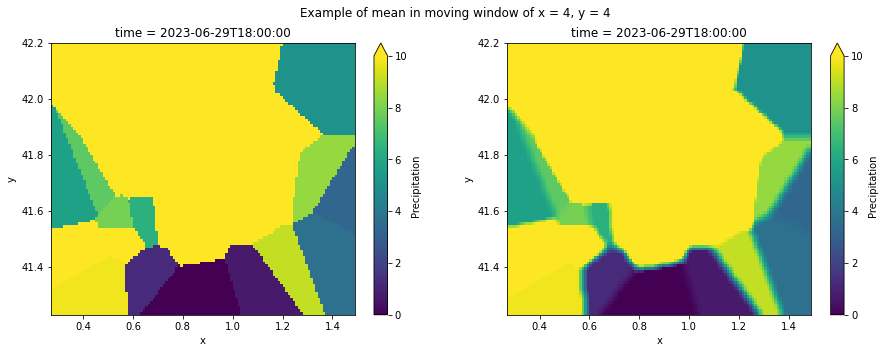

In [44]:
# EXAMPLE
xwin = 4
ywin = 4
test_arr = all_xr_near_prec.sel(time="20230629T18").Precipitation.load()
fig, axs = plt.subplots(1,2, figsize = (15,5))
test_arr.plot(ax=axs[0], vmin = 0, vmax = 10)
test_out = test_arr.rolling({'x':xwin,'y':ywin}, center=True, min_periods = 1).mean()
test_out.plot(ax=axs[1], vmin = 0, vmax = 10)
ttl = fig.suptitle(f'Example of mean in moving window of x = {xwin}, y = {ywin}')

In [45]:
outfile_prec_1km_movwin = outfold / f"MovWinMeanNearest_Prec1km_{len(selected_stations):02d}stations_from{start_date.replace('/','')}to{end_date.replace('/','')}.zarr"
# at = shapefile.to_crs(4326).dissolve()
at = shapefile.to_crs(meteocat_stations.crs).buffer(buff, cap_style=3, join_style=3).to_crs(shapefile.crs)
if not outfile_prec_1km_movwin.exists():
    all_xr_movwin = all_xr_near_prec.rolling({'x':xwin,'y':ywin}, center=True, min_periods = 1).mean().load()
    all_xr_movwin = all_xr_movwin.interpolate_na(dim=["x","y"], method = "nearest", use_coordinate = ["x","y"])
    all_xr_movwin.to_zarr(outfile_prec_1km_movwin)
else:
    all_xr_movwin = xr.open_zarr(outfile_prec_1km_movwin)

### APPROACH chosen = Nearest Neighbour + moving window average (x=4,y=4)
##### Appling same method to Temperature data (with an additional first step temporal smoothing=30 day smoothed)

WARNING *** file size (33793) not 512 + multiple of sector size (512)


1: 0K 




Index(['T_Baldomar'], dtype='object')
WARNING *** file size (33793) not 512 + multiple of sector size (512)


2: 0K 




Index(['T_Baldomar', 'T_Alguaire'], dtype='object')
WARNING *** file size (33793) not 512 + multiple of sector size (512)


3: 0K 




Index(['T_Baldomar', 'T_Alguaire', 'T_Algerri'], dtype='object')
WARNING *** file size (33793) not 512 + multiple of sector size (512)


4: 0K 




Index(['T_Baldomar', 'T_Alguaire', 'T_Algerri', 'T_Alfarràs'], dtype='object')
WARNING *** file size (33793) not 512 + multiple of sector size (512)


5: 0K 




Index(['T_Baldomar', 'T_Alguaire', 'T_Algerri', 'T_Alfarràs',
       'T_Alcarràs - Torrent d'Alcarràs'],
      dtype='object')
WARNING *** file size (33793) not 512 + multiple of sector size (512)


6: 0K 




Index(['T_Baldomar', 'T_Alguaire', 'T_Algerri', 'T_Alfarràs',
       'T_Alcarràs - Torrent d'Alcarràs', 'T_Albesa'],
      dtype='object')
WA

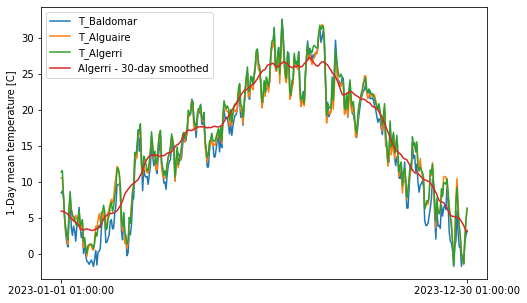

In [46]:
ds = pd.Timestamp(start_date)
de = pd.Timestamp(end_date)
file_all_meteostations = outfold / f"Temperature_{len(selected_stations):02d}stations_from{start_date.replace('/','')}to{end_date.replace('/','')}.csv"
### EXTRACT From gencat agrometeo stations website (or read if already downloaded)
if not file_all_meteostations.exists():
    for it, (idStation,name) in enumerate(zip(selected_stations.idEstaciones, selected_stations.names)):
        tot_years = []
        for year in np.arange(ds.year, de.year+1): # divide per year (otherwise problems with API)
#             print(name, year)
            initial_date = f"01/01/{year}"
            final_date   = f"31/12/{year}"
            tot_years.append(read_meteo_stations_in_pandas(idStation,date_start=initial_date,date_end=final_date, variables = [1000]))
        temp_single_station = pd.concat(tot_years)
        date = temp_single_station['Data'].apply(pd.to_datetime, format = '%d/%m/%Y')
        hour = temp_single_station['Hora'].apply(lambda x: int(x[0:2]))
        dates = [dd+pd.to_timedelta(hh,'H') if hh<24 else dd+pd.to_timedelta(1,'D') for dd,hh in zip(date,hour)]
        temp_single_stationn = pd.DataFrame(temp_single_station['Temperatura mitjana diària'].values, index = dates, columns = [f'T_{name}'])
        temp_single_stationn = temp_single_stationn.replace({"--":np.nan}).astype(float).groupby(temp_single_stationn.index).mean()
        if it==0:
            tt_tot = temp_single_stationn.copy()
        else:
            tt_tot = pd.merge(tt_tot,temp_single_stationn, right_index=True, left_index=True, how = 'outer')
        print(f"\n\n{len(tt_tot.columns)}: {len(tt_tot)//1000}K \n\n\n\n")
        print(tt_tot.columns)
    tt_tot2= tt_tot.replace('--', np.nan)
    tt_tot2.to_csv(file_all_meteostations)
else:
    tt_tot2 = pd.read_csv(file_all_meteostations, index_col=0,parse_dates=True)
tt_tot2 = tt_tot2.rename(columns = {c:c.replace('Prec[mm]_','') for c in tt_tot2.columns})
tt_tot3 = tt_tot2.rolling(30, min_periods = 1, center = True).mean() 
##### PLOT Insitu Precipitation ###############################################
fig, ax = plt.subplots(figsize = (8,5))
ax = tt_tot2.iloc[:,0:3].plot(ax=ax, use_index = False)
tt_tot3.plot(y = 'T_Algerri', ax=ax, color = 'tab:red', use_index = False, label = 'Algerri - 30-day smoothed')
ax.set_xticks([0,len(tt_tot2)-1], [tt_tot2.index[0],tt_tot2.index[-2]])
# ax = add_nice_xaxis(ax)
lbl = ax.set_ylabel('1-Day mean temperature [C]')
################################################################################

In [47]:
outfile_temp_1km = outfold /'TEMPERATURE'/ f"nearestneighbour_temp1km_Urgell_{len(selected_stations):02d}stations_from{start_date.replace('/','')}to{end_date.replace('/','')}.zarr"
outfile_temp_1km_movwin = outfold /'TEMPERATURE'/ f"MovWinMeanNearest_temp1km_Urgell_{len(selected_stations):02d}stations_from{start_date.replace('/','')}to{end_date.replace('/','')}.zarr"

# at = shapefile.to_crs(4326).dissolve()
at = shapefile.to_crs(meteocat_stations.crs).buffer(buff, cap_style=3, join_style=3).to_crs(shapefile.crs)

xwin = 4
ywin = 2
if not outfile_temp_1km.exists():
    xmin, ymin, xmax, ymax = at.geometry[0].bounds
    ff = xr.open_dataset(example_file, engine = 'rasterio', masked=True).rio.write_crs('EPSG:4326')
    ff2 = ff.rio.clip([box(xmin, ymin, xmax, ymax)], from_disk=True, all_touched=True)

    xg = ff2.x.values
    yg = ff2.y.values
    X, Y = np.meshgrid(xg, yg)
    
    xx = selected_stations.to_crs('EPSG:4326').geometry.x.values
    yy = selected_stations.to_crs('EPSG:4326').geometry.y.values
    vals = np.array([xx,yy]).T
    all_xr_temp = []

    for tim, zz in tqdm.tqdm(tt_tot3.iterrows(), total = len(tt_tot3)):
#         f = NearestNDInterpolator(vals,zz.astype(float))
#         datas = f(X,Y)
#         datas = np.where(datas<0, 0, datas)
        f = NearestNDInterpolator(vals[~zz.isna()],zz.dropna().astype(float))
        datas = f(X,Y)
        datas = np.where(datas<0, 0, datas)
        all_xr_temp.append(xr.DataArray(datas, coords=[('y',yg),('x',xg)]))
    tt_tot3.index.name  = 'time'
    all_xr_near_temp = xr.concat(all_xr_temp, dim = tt_tot3.index).to_dataset(name = 'DailyTemperature')
    all_xr_near_temp.to_zarr(outfile_temp_1km)
else:
    all_xr_near_temp = xr.open_zarr(outfile_temp_1km)
    
if not outfile_temp_1km_movwin.exists():
    all_xr_movwin_temp = all_xr_near_temp.rolling({'x':xwin,'y':ywin}, center=True, min_periods = 1).mean().load()
    all_xr_movwin_temp = all_xr_movwin_temp.interpolate_na(dim=["x","y"], method = "nearest", use_coordinate = ["x","y"])
    all_xr_movwin_temp.to_zarr(outfile_temp_1km_movwin)
else:
    all_xr_movwin_temp = xr.open_zarr(outfile_temp_1km_movwin)


100%|██████████| 365/365 [00:01<00:00, 212.60it/s]


In [ ]:
# ### NDVI from MODIS - 16 days product 
# folder_data_modis_h18v04 = Path('/mnt/RAID2/MODIS/processed/h18v04/ndvi')
# file_ndvi_zarr = outfold.parent / 'MODIS_NDVI' / 'MODIS_NDVI1km_Lleida_11stations_from01012010to31122023.zarr'
# file_ndvi_zarr.parent.mkdir(exist_ok = True)
# all_files_ndvi = list(folder_data_modis_h18v04.glob('*/NDVI*.asc'))
# all_files_ndvi.sort()
# if not file_ndvi_zarr.exists():
#     at = shapefile.to_crs(meteocat_stations.crs).buffer(buff, cap_style=3, join_style=3).to_crs(shapefile.crs)
#     gg = box(*at.to_crs(4326).total_bounds)
#     times = []
#     res = []
#     for file in tqdm.tqdm(all_files_ndvi, total = len(all_files_ndvi)):
#         date = pd.to_datetime(file.parent.name.split('.A')[1].split('.')[0], format = '%Y%j')
#         try:
#             ff = xr.open_dataset(file,engine = 'rasterio',masked=True).rio.write_crs('EPSG:4326')
#             ff2 = ff.rio.clip([gg], from_disk=True, all_touched=True)
#             ff2 = 1e-4 *ff2
#             res.append(ff2.band_data.sel(band = 1))
#             times.append(date)
#         except Exception as e:
#             print(e)
#             print(f'File {file.parent.name}')
#     time = pd.Series(index = times)
#     time.index.name  = 'time'
#     all_xr_ndvi = xr.concat(res, dim = time.index).to_dataset(name = 'MODIS_NDVI')
#     all_xr_ndvi.to_zarr(file_ndvi_zarr)
# else:
#     all_xr_ndvi = xr.open_zarr(file_ndvi_zarr)